First, I tried to predict neural response with simple interpretable parameters.  
The model introduced here does not perform as well as CNN based model does.  
However, in a few cells, this can tell us why some images evoked stronger responses than others

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['spike_data.nc', 'sub.csv', 'train.csv', 'stim_wpos_dva.csv', 'stim.npy']


In [2]:
import matplotlib.pyplot as plt

# image processing modules
from scipy import ndimage
from skimage.filters import gabor_kernel
from skimage.draw import circle

# stat modules
from scipy.stats import kurtosis;
from scipy.stats import zscore;

# dimension reduction, fitting modules
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV;

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [3]:
# load the stimuli with numpy
stim = np.load('../input/stim.npy')
df = pd.read_csv('../input/train.csv')
df.index = df.Id#turn the first col to index
df = df.iloc[:,1:]#get rid of first col that is now index
df.head()

,10_1_2018_0_0,10_1_2018_0_1,11_06_18_0_0,11_06_18_0_1,11_07_18_0_0,11_07_18_1_0,11_08_18_0_0,11_08_18_0_1,11_09_18_0_1,9_17_2018_0_0,9_17_2018_0_1,9_20_2018_0_0,9_21_2018_0_0,9_21_2018_0_1,9_26_2018_0_0,9_26_2018_0_1,9_28_2018_0_0,9_28_2018_0_1
Id,,,,,,,,,,,,,,,,,,
50,6.782330,1.414214,5.622356,1.172872,3.835296,9.107331,2.928577,1.002235,0.900420,6.174053,0.500000,3.813243,2.146952,1.668328,1.976085,0.788675,6.557439,1.414214
51,8.124038,1.000000,6.561819,0.477671,2.642316,6.778426,4.691500,0.596407,1.675685,6.269141,0.333333,3.589276,2.924137,2.961930,1.932416,0.166667,6.000000,0.000000
52,8.544004,0.000000,6.707088,0.892229,1.457884,4.877056,3.632468,1.812880,0.728759,6.771823,0.804738,4.632351,2.833196,1.696923,2.354642,0.955342,4.000000,0.000000
53,8.062258,2.000000,6.980861,0.699075,4.991866,9.280055,5.040368,0.181818,2.019465,6.531085,0.166667,4.502757,2.995157,1.199359,3.094110,2.474990,8.944272,0.000000
54,8.306624,1.414214,5.663736,0.284518,3.183899,8.674227,5.017551,0.272727,1.197206,6.007232,0.166667,3.573848,2.647334,1.646386,1.009994,1.288675,6.403124,0.000000


**Preferred & nonpreferred images**   
For example, let's see cell 2 & 13  
Cell 2: Preference for high SF ???    
Cell 13: Preference for a curvature (or orientation) ???


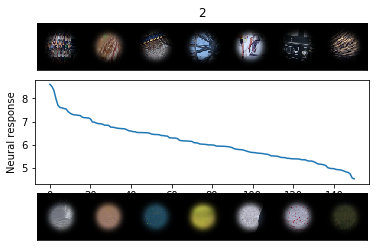

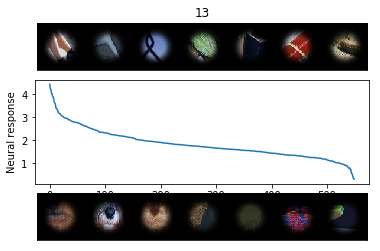

In [4]:
for s in [2,13]:
    res = df.iloc[:,s];
    res = res.dropna();
    res = res.sort_values(ascending=False);

    for i in np.arange(0,7):
        # best 7 (top) & worst 7 stimuli (bottom) were added to ImgMtx (Image Matrix)
        ImgPair = np.append(stim[res.index[i]],stim[res.index[-(i+1)]],axis=0);
        if i==0:
            ImgMtx = ImgPair;
        else:
            ImgMtx = np.append(ImgMtx,ImgPair,axis=1);
    plt.figure();       
    # best 7 stimuli
    plt.subplot(4,1,1);    
    plt.imshow(ImgMtx[:80,:,:]);   plt.xticks([]);plt.yticks([])
    plt.title(s);
    # neural responses (from best to worst)
    plt.subplot(4,1,(2,3));   
    plt.plot(np.arange(0,len(res.values)),res.values);
    plt.ylabel('Neural response')
    # worst 7 stimuli
    plt.subplot(4,1,4);   
    plt.imshow(ImgMtx[80:,:,:]);   plt.xticks([]);plt.yticks([])
    plt.draw();

We know that V1 cells are well characterized by orientation x spatial frequency.  
And we believe that more complicated features are encoded by the combinations of V1-like filters.   
Here, I prepared 32 V1-like Gabor filters (4 spatial frequencies x 8 orientations)

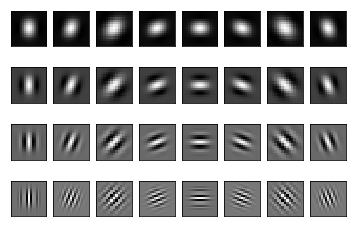

In [5]:
GKs = [];
for frequency in (0.05,0.1,0.2,0.4): ## indicates Number of cycles / pixel 
    for theta in range(8):    
        theta = theta*np.pi/8;
        GK = np.real(gabor_kernel(frequency,theta,sigma_x=3,sigma_y=3));       
        GKs.append(GK);

for i in range(len(GKs)):
    plt.subplot(4,8,i+1);
    plt.imshow(GKs[i],cmap='gray');           
    plt.xticks([]); plt.yticks([]);

**Compute Gabor filter outputs for an example image**   
Each panel shows absolute value of convolution output.   
Row: from low to high SF  
Column: Different orientations  

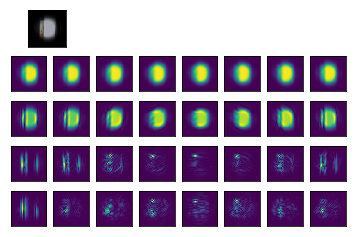

In [6]:
sNum = 415; # 109,415
imgNow = np.mean(stim[sNum],2);
FoutAll = [];
plt.figure();
plt.subplot(5,4,1);   
plt.imshow(stim[sNum]);   plt.xticks([]);plt.yticks([])

for fNum in range(0,len(GKs)):
    Fout = ndimage.convolve(imgNow,GKs[fNum]);
    Fout = abs(Fout)
    plt.subplot(5,8,fNum+9);
    plt.imshow(Fout);    
    #plt.imshow(Fout,cmap='gray');
    plt.xticks([]);plt.yticks([])
    FoutAll.append(Fout);
    
# It seems that overall structure of an image is better reflected in low SF output (first two rows).
# Relative difference depending on orientation (e.g., dominance of vertical orientation) is better reflected 
#   in high SF output (bottom two rows)


**Image feature extraction**

In [7]:
Ori_out = [];   SF_out = [];   
RGB_out = [];   Lum_out = [];
Dir_out = [];   Cont_out = [];
GS_out = [];

for sNum in range(0,len(stim)):    
    imgGray = np.mean(stim[sNum],2);   

    GK_Now = np.zeros((4,8));
    for f in range(0,8): # 8 orientations
        for k in range(0,4): # 4 SF levels
            FoutNow = ndimage.convolve(imgGray,GKs[f+k*8],mode='reflect');               
            FoutNow = abs(FoutNow);            
            GK_Now[k,f] = np.sum(FoutNow);

    # Relative strengths of 8 orientation (z-score) outputs from a given image
    # Only high SF (bottom two rows) is considered
    Ori_Now = np.mean(zscore(GK_Now[2:,:],axis=1),axis=0);
    Ori_out.append(Ori_Now);
    
    # If an image is directional, Ori_Now will have big (+ or -) z-score
    Dir_out.append(np.max(abs(Ori_Now)));
    
    # High SF output / Low SF output: high values indicates high SF tuned
    SF_Now = np.sum(GK_Now,axis=1);
    SF_out.append(np.sum(SF_Now[2:])/np.sum(SF_Now[:2]));
    
    # Relative strength of RGB channels (z-score) 
    RGB_now = np.mean(stim[sNum],(0,1));
    RGB_now = RGB_now.reshape((1,3));
    RGB_out.append(zscore(RGB_now,axis=1));    

    # Luminance: mean of RGB values
    Lum_out.append(imgGray.mean());

    ### Contrast index: std(grayDistribution)/(kurtosis(grayDistribution)**(1/4));
    ### Tamura, H., Mori, S., & Yamawaki, T. (1978). Textural features corresponding to visual perception. 
    ### Only pixels within the circular boundary were considered
    rr,cc = circle(40,40,25);
    gLevel = np.zeros((len(rr),1));
    for i in range(len(rr)):
        gLevel[i,0] = imgGray[rr[i],cc[i]];
    Cont_outNow = np.std(gLevel)/(kurtosis(gLevel,fisher=False)**(1/4));    
    Cont_out.append(Cont_outNow);
    
    ### Global structure from Low SF output
    GS_Now = [];
    for f in range(0,8):
        ### LowPass: 2nd row in the GK panels
        FoutNow = ndimage.convolve(imgGray,GKs[f+8],mode='reflect');   
        FoutNow = abs(FoutNow);
        if f==0:
            LPout = FoutNow;
        else:
            LPout = LPout + FoutNow;
    
    LPout = LPout[10:70,10:70];
    LPout = np.reshape(LPout,(1,-1));
    GS_out.append(LPout); 
    
    if sNum in [100,200,300,400,500,600]:
        print(sNum,' was computed');       

    
GS_out = np.array(GS_out);
GS_out = np.reshape(GS_out,(len(stim),-1));    

Ori_out = np.array(Ori_out);
Ori_out[600,:] = 0;

SF_out = np.array(SF_out);
SF_out = np.reshape(SF_out,(len(stim),-1));  
SF_out[600,:] = 0;
  
RGB_out = np.array(RGB_out);
RGB_out = np.reshape(RGB_out,(len(RGB_out),-1));
RGB_out[600,:] = 0

Lum_out = np.array(Lum_out);
Lum_out = np.reshape(Lum_out,(len(stim),-1));    

Dir_out = np.array(Dir_out);
Dir_out = np.reshape(Dir_out,(len(stim),-1));    
Dir_out[600,:] = 0;

Cont_out = np.array(Cont_out); 
Cont_out[600,0] = 0; 

100  was computed
200  was computed
300  was computed
400  was computed
500  was computed
600  was computed


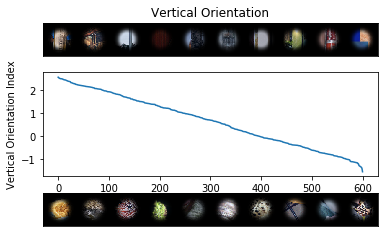

In [8]:
# Extracted features
# Vertical orientation
Ori = pd.DataFrame(Ori_out)
VertOri = Ori.iloc[:,0].sort_values(ascending=False);

for i in np.arange(0,10):
    # best 10 (top) & worst 10 stimuli (bottom) were added to ImgMtx (Image Matrix)
    ImgPair = np.append(stim[VertOri.index[i]],stim[VertOri.index[-(i+1)]],axis=0);
    if i==0:
        ImgMtx = ImgPair;
    else:
        ImgMtx = np.append(ImgMtx,ImgPair,axis=1);

plt.figure();       
# best 10 stimuli
plt.subplot(4,1,1);    
plt.imshow(ImgMtx[:80,:,:]);   plt.xticks([]);plt.yticks([])
plt.title('Vertical Orientation');
# neural responses (from best to worst)
plt.subplot(4,1,(2,3));   
plt.plot(np.arange(0,len(VertOri.values)),VertOri.values);
plt.ylabel('Vertical Orientation Index')
# worst 10 stimuli
plt.subplot(4,1,4);   
plt.imshow(ImgMtx[80:,:,:]);   plt.xticks([]);plt.yticks([])
plt.draw();

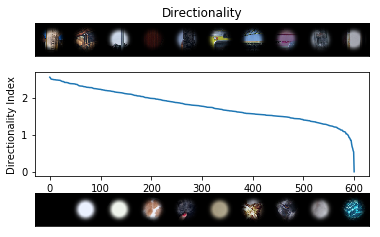

In [9]:
# Extracted features
# Directionality
Dir = pd.DataFrame(Dir_out)
Dir = Dir.iloc[:,0].sort_values(ascending=False);

for i in np.arange(0,10):
    # best 10 (top) & worst 10 stimuli (bottom) were added to ImgMtx (Image Matrix)
    ImgPair = np.append(stim[Dir.index[i]],stim[Dir.index[-(i+1)]],axis=0);
    if i==0:
        ImgMtx = ImgPair;
    else:
        ImgMtx = np.append(ImgMtx,ImgPair,axis=1);

plt.figure();       
# best 10 stimuli
plt.subplot(4,1,1);    
plt.imshow(ImgMtx[:80,:,:]);   plt.xticks([]);plt.yticks([])
plt.title('Directionality');
# neural responses (from best to worst)
plt.subplot(4,1,(2,3));   
plt.plot(np.arange(0,len(Dir.values)),Dir.values);
plt.ylabel('Directionality Index')
# worst 10 stimuli
plt.subplot(4,1,4);   
plt.imshow(ImgMtx[80:,:,:]);   plt.xticks([]);plt.yticks([])
plt.draw();

## Directional images regardless of orientation

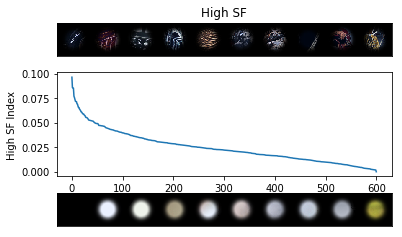

In [10]:
# Extracted features
# High SF
SF = pd.DataFrame(SF_out)
highSF = SF.iloc[:,0].sort_values(ascending=False);

for i in np.arange(0,10):
    # best 10 (top) & worst 10 stimuli (bottom) were added to ImgMtx (Image Matrix)
    ImgPair = np.append(stim[highSF.index[i]],stim[highSF.index[-(i+1)]],axis=0);
    if i==0:
        ImgMtx = ImgPair;
    else:
        ImgMtx = np.append(ImgMtx,ImgPair,axis=1);

plt.figure();       
# best 10 stimuli
plt.subplot(4,1,1);    
plt.imshow(ImgMtx[:80,:,:]);   plt.xticks([]);plt.yticks([])
plt.title('High SF');
# neural responses (from best to worst)
plt.subplot(4,1,(2,3));   
plt.plot(np.arange(0,len(highSF.values)),highSF.values);
plt.ylabel('High SF Index')
# worst 10 stimuli
plt.subplot(4,1,4);   
plt.imshow(ImgMtx[80:,:,:]);   plt.xticks([]);plt.yticks([])
plt.draw();

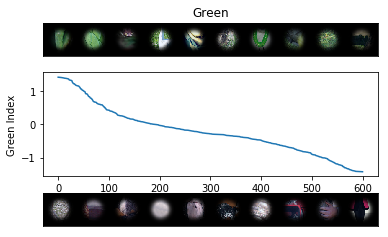

In [11]:
# Extracted features
# Green
RGB = pd.DataFrame(RGB_out)
Green = RGB.iloc[:,1].sort_values(ascending=False);

for i in np.arange(0,10):
    # best 10 (top) & worst 10 stimuli (bottom) were added to ImgMtx (Image Matrix)
    ImgPair = np.append(stim[Green.index[i]],stim[Green.index[-(i+1)]],axis=0);
    if i==0:
        ImgMtx = ImgPair;
    else:
        ImgMtx = np.append(ImgMtx,ImgPair,axis=1);

plt.figure();       
# best 10 stimuli
plt.subplot(4,1,1);    
plt.imshow(ImgMtx[:80,:,:]);   plt.xticks([]);plt.yticks([])
plt.title('Green');
# neural responses (from best to worst)
plt.subplot(4,1,(2,3));   
plt.plot(np.arange(0,len(Green.values)),Green.values);
plt.ylabel('Green Index')
# worst 10 stimuli
plt.subplot(4,1,4);   
plt.imshow(ImgMtx[80:,:,:]);   plt.xticks([]);plt.yticks([])
plt.draw();

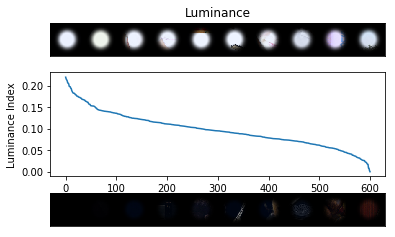

In [12]:
# Extracted features
# Luminance
Lum = pd.DataFrame(Lum_out)
Lum = Lum.iloc[:,0].sort_values(ascending=False);

for i in np.arange(0,10):
    # best 10 (top) & worst 10 stimuli (bottom) were added to ImgMtx (Image Matrix)
    ImgPair = np.append(stim[Lum.index[i]],stim[Lum.index[-(i+1)]],axis=0);
    if i==0:
        ImgMtx = ImgPair;
    else:
        ImgMtx = np.append(ImgMtx,ImgPair,axis=1);

plt.figure();       
# best 10 stimuli
plt.subplot(4,1,1);    
plt.imshow(ImgMtx[:80,:,:]);   plt.xticks([]);plt.yticks([])
plt.title('Luminance');
# neural responses (from best to worst)
plt.subplot(4,1,(2,3));   
plt.plot(np.arange(0,len(Lum.values)),Lum.values);
plt.ylabel('Luminance Index')
# worst 10 stimuli
plt.subplot(4,1,4);   
plt.imshow(ImgMtx[80:,:,:]);   plt.xticks([]);plt.yticks([])
plt.draw();

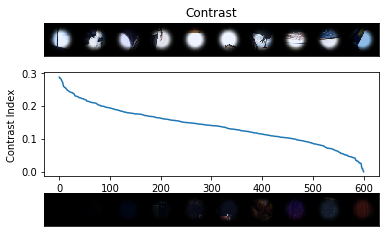

In [13]:
# Extracted features
# Contrast
Cont = pd.DataFrame(Cont_out)
Cont = Cont.iloc[:,0].sort_values(ascending=False);

for i in np.arange(0,10):
    # best 10 (top) & worst 10 stimuli (bottom) were added to ImgMtx (Image Matrix)
    ImgPair = np.append(stim[Cont.index[i]],stim[Cont.index[-(i+1)]],axis=0);
    if i==0:
        ImgMtx = ImgPair;
    else:
        ImgMtx = np.append(ImgMtx,ImgPair,axis=1);

plt.figure();       
# best 10 stimuli
plt.subplot(4,1,1);    
plt.imshow(ImgMtx[:80,:,:]);   plt.xticks([]);plt.yticks([])
plt.title('Contrast');
# neural responses (from best to worst)
plt.subplot(4,1,(2,3));   
plt.plot(np.arange(0,len(Cont.values)),Cont.values);
plt.ylabel('Contrast Index');
# worst 10 stimuli
plt.subplot(4,1,4);   
plt.imshow(ImgMtx[80:,:,:]);   plt.xticks([]);plt.yticks([])
plt.draw();

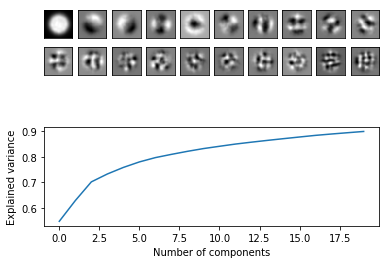

In [14]:
# Visualize principal components of global structure
Ncomp = 20;
pca = PCA(Ncomp);
pca.fit(GS_out);    
pixHV = int(np.sqrt(GS_out.shape[1]));

plt.figure();
for i in range(Ncomp):
    plt.subplot(6,10,i+1);
    plt.imshow(pca.components_[i].reshape(pixHV,-1),cmap='gray');
    plt.xticks([]);plt.yticks([])
plt.subplot(2,1,2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components');
plt.ylabel('Explained variance');


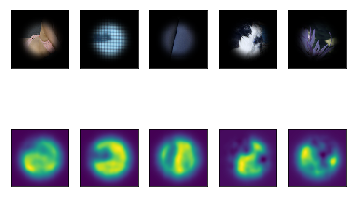

In [15]:
# image reconstruction from principal components
components = pca.transform(GS_out);
projected = pca.inverse_transform(components);

sNumStart = 30
plt.figure()
for i in range(0,5):
    sNum = sNumStart + i;
    plt.subplot(2,5,i+1);
    plt.imshow(stim[sNum]); 
    plt.xticks([]);plt.yticks([])
    plt.subplot(2,5,i+6);
    plt.imshow(projected[sNum].reshape(pixHV,-1)); 
    plt.xticks([]);plt.yticks([])

In [16]:
##### independent variables
PCAcomponents = pca.transform(GS_out);
PCAcomponentsZ = zscore(PCAcomponents);

OriZ = zscore(Ori_out);
SFZ = zscore(SF_out);
RGBZ = zscore(RGB_out);
LumZ = zscore(Lum_out);
DirZ = zscore(Dir_out);
ContZ = zscore(Cont_out);

IndVar = np.concatenate((PCAcomponentsZ,OriZ,SFZ,RGBZ,LumZ,DirZ,ContZ),axis=1);
IndVar_FN = (['PCA_' + str(i) for i in range(20)] + ['Ori_' + str(i) for i in range(8)] 
             + ['SF'] + ['RGB_' + str(i) for i in range(3)]
             + ['Lum'] + ['SF'] + ['Cont']);
IndVar_FN = pd.DataFrame(IndVar_FN,columns=['Filter']);

############
0  was done
        Corr   absCorr Filter
28  0.175267  0.175267     SF
1  -0.122321  0.122321  PCA_1
32 -0.114677  0.114677    Lum
0  -0.110875  0.110875  PCA_0
26  0.102223  0.102223  Ori_6
############
1  was done
        Corr   absCorr Filter
29 -0.134727  0.134727  RGB_0
31  0.122643  0.122643  RGB_2
5   0.103823  0.103823  PCA_5
28 -0.076955  0.076955     SF
34 -0.062869  0.062869   Cont
############
2  was done
        Corr   absCorr Filter
28  0.599248  0.599248     SF
5  -0.228790  0.228790  PCA_5
23  0.172135  0.172135  Ori_3
4   0.154439  0.154439  PCA_4
32 -0.135420  0.135420    Lum
############
3  was done
        Corr   absCorr Filter
28  0.353103  0.353103     SF
32 -0.244291  0.244291    Lum
0  -0.242221  0.242221  PCA_0
30 -0.185314  0.185314  RGB_1
34 -0.171087  0.171087   Cont
############
4  was done
        Corr   absCorr  Filter
29  0.252498  0.252498   RGB_0
31 -0.245890  0.245890   RGB_2
2   0.153510  0.153510   PCA_2
7  -0.147879  0.147879   PCA_7


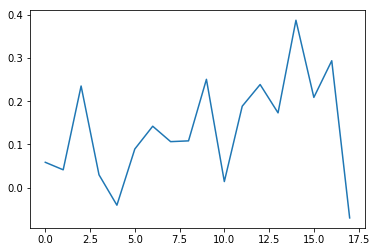

In [17]:
params = {'C': [0.1,0.2,0.5,1,2,5,10],'kernel': ['rbf'],'gamma': ['auto']};

score = [];   score2 = [];
test_preds = [];
for i in range(0,df.shape[1]):
    ydata = df.iloc[:,i].dropna();
    ydata = np.array(ydata);
    
    corrMtxNow = [];
    ydata = df.iloc[:,i].dropna();
    for j in range(0,IndVar.shape[1]):    
        corrMtxNow.append(np.corrcoef(IndVar[50:50+len(ydata),j],ydata)[0,1]);
    corrMtxNow = np.array(corrMtxNow);    
    corrMtxNow = np.reshape(corrMtxNow,(len(corrMtxNow),-1));
    corrMtxNowB = np.abs(corrMtxNow);    
    corrMtx = pd.DataFrame(np.concatenate((corrMtxNow,corrMtxNowB),axis=1)
                            ,columns=['Corr','absCorr']);
    
    corrMtx = pd.concat([corrMtx,IndVar_FN],axis=1);
    corrMtx.sort_values('absCorr',ascending=False,inplace=True);
    
    Ncomp = len(corrMtx);

    xdata = IndVar[50:50+len(ydata),corrMtx.index[:Ncomp]];
    xTest = IndVar[:50,corrMtx.index[:Ncomp]];
    
    ydataZ = (ydata - ydata.mean())/ydata.std();    
    
    clf = GridSearchCV(SVR(),params);
    clf.fit(xdata,ydataZ);
    score.append(clf.best_score_);

    recon = clf.predict(xTest)*ydata.std() + ydata.mean();
    test_preds.append(recon);
    
    print('############');
    print(i,' was done');
    print(corrMtx.head(5));    

plt.plot(score);


In [18]:
##### save output    
test_preds = np.array(test_preds)#convert predictions to array
test_preds = np.reshape(test_preds,(18,50));
sdf = pd.DataFrame(test_preds.T)
sdf.columns = df.columns#replace the columns with the correct cell ids from training data
sdf.index.name = 'Id'
sdf.to_csv('sub.csv')#save to csv

# Private score 0.76800, Public score 0.82540